In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import time
from dcr.recognition import *

Using TensorFlow backend.


In [2]:
def show(img, figsize=(10, 10)):
    figure = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


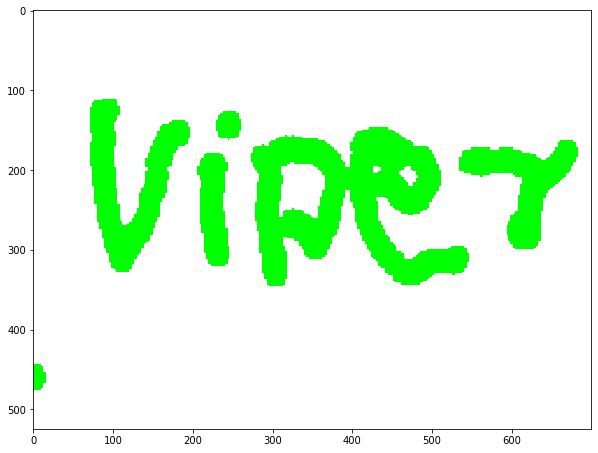






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


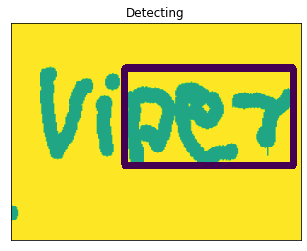

The prediction accuracy for  श  is  99.99 %


In [5]:
def running_average(bg_img, image, aweight):
    if bg_img is None:
        bg_img = image.copy().astype("float")
    else:
        cv2.accumulateWeighted(image, bg_img, aweight)    
    return bg_img

def get_contours(bg_img, image, threshold=10):
    
    # abs diff betn img and bg
    diff = cv2.absdiff(bg_img.astype("uint8"), image)    
    _, th = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
    (cnts, _) = cv2.findContours(th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(cnts) == 0:
        return None
    else:
        max_cnt = max(cnts, key=cv2.contourArea)
        return th, max_cnt

#accumulate weight variable
aweight = 0.5
# strat the camera
cam = cv2.VideoCapture(0)
# ROI box
top, right, bottom, left = 250, 400, 480, 640
# count frame
num_frames=0
# writing canvas
canvas = None
# thickness
t=3
# draw color(ink color)
draw_color = (0, 255, 0)
# pointer color
pointer_color = (255, 0, 0)
# mode flag
erase = False
# flag to indicate take average
take_average=True
#bg image
bg_img=None
# loop while everything is true
while True:
    # read the camera result
    (ret, frame) = cam.read()
    # if camera has read frame
    if ret:
        # wait for 1ms to key press
        key = cv2.waitKey(1) & 0xFF
        frame = imutils.resize(frame, width=700)
        # flip to remove mirror effect
        frame = cv2.flip(frame, 1)
        # clone it to not mess with real frame
        clone = frame.copy()
        h, w = frame.shape[:2]
        # take roi, to send it onto contour/average extraction
        roi = frame[top:bottom, right:left]
        # roi to grayscale
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        # add GaussianBlur to eliminate some noise
        gray = cv2.GaussianBlur(gray, (7, 7), 0)
        
        # if to take average and num frames on average taking is lesser than 
        if num_frames<100 and take_average==True:
            # perform running average
            bg_img = running_average(bg_img, gray, aweight)
            # put frame number on frame
            cv2.putText(clone, str(num_frames), (100, 100),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 5)
            num_frames+=1
        # if not to take average
        else:
            num_frames=0                        
            # take our segmented hand
            hand = get_contours(bg_img, gray)
            take_average=False
            if hand is not None:
                
                # if pressed x, erase
                if chr(key) == "x":
                    draw_color = (255, 255, 255)
                    pointer_color = (0, 0, 255)
                    erase = True
                if chr(key) == "c":
                    draw_color = (0, 255, 0)
                    pointer_color = (255, 0, 0)
                    erase = False
                #idle
                if chr(key) == "z":
                    erase = None
                    pointer_color = (0, 0, 0)                   
                # restart system
                if chr(key) == "r":
                    take_average=True
                    canvas = None
                if chr(key) == "e":
                    canvas = None
                    drawn = np.zeros(drawn.shape)+255
                
                
                                    
                thresholded, segmented = hand
                cv2.drawContours(clone, [segmented+(right,top)], -1, (0, 0, 255))   
                
                tshape = thresholded.shape
                sshape = segmented.shape
                new_segmented = segmented.reshape(sshape[0], sshape[-1])
                m = new_segmented.min(axis=0)
                
                if type(canvas) == type(None):
                    canvas = np.zeros((tshape[0], tshape[1], 3))+255
                
                c = np.zeros(canvas.shape, dtype=np.uint8)
                cv2.circle(c, (m[0], m[1]), 5, pointer_color, -3)
                cv2.circle(clone, (right+m[0], top+m[1]), 5, pointer_color, -3)
                
                if erase==True:
                    cv2.circle(canvas, (m[0], m[1]), 5, draw_color, -3)
                    erimg=cv2.circle(canvas.copy(), (m[0], m[1]), 5, (0, 0, 0), -3)            
                    cv2.circle(c, (m[0], m[1]), 5, (0, 0, 255), -3)
                    e = cv2.erode(erimg, (3, 3), iterations=5)
                    drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                    c = cv2.resize(c, (clone.shape[1], clone.shape[0]))
                    drawn_new = drawn+c
                    cv2.imshow("Drawing", drawn+c)
                    erimg=cv2.circle(canvas.copy(), (m[0], m[1]), 5, (255, 255, 255), -3)            
                    cv2.circle(c, (m[0], m[1]), 5, (0, 0, 255), -3)
                    e = cv2.erode(erimg, (3, 3), iterations=5)
                    drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))                    
                elif erase==False:
                    #cv2.imshow("Thresholded", c)
                    cv2.circle(canvas, (m[0], m[1]), 5, draw_color, -3)
                    e = cv2.erode(canvas, (3, 3), iterations=5)
                    drawn = cv2.resize(e, (clone.shape[1], clone.shape[0]))
                    c = cv2.resize(c, (clone.shape[1], clone.shape[0]))
                    drawn_new = drawn+c
                    cv2.imshow("Drawing", drawn+c)
                elif erase == None:
                    canvas_shape = canvas.shape
                    clone_shape = clone.shape
                    eshape = (clone_shape[0]/canvas_shape[0], clone_shape[1]/canvas_shape[1])
                    m[0] = int(eshape[1]*m[0])
                    m[1] = int(eshape[0]*m[1])
                    drawn = cv2.resize(drawn, (clone.shape[1], clone.shape[0]))
                    dc = drawn.copy()  
                    cv2.circle(dc, (m[0], m[1]), 10, pointer_color, -3)
                    
                    cv2.imshow("Drawing", dc)
                
        if chr(key) == "s":
            show(drawn)
            d = drawn.copy().astype(np.uint8) 
            r = recognition(cv2.cvtColor(d, cv2.COLOR_BGR2GRAY), 'show')
            cv2.imshow("Detection", r)
            
        # draw a ROI
        cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)
        # show live feed
        cv2.imshow("Feed", clone)
        
        if key == 32:
            cv2.imwrite("Captured.png", clone)
        # if pressed  escape, loop out and stop processing
        if key==27:
            break
cam.release()
cv2.destroyAllWindows()
    
            

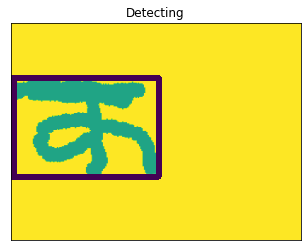

The prediction accuracy for  क  is  100.00 %


In [7]:
# r = recognition(cv2.cvtColor(drawn, cv2.COLOR_BGR2GRAY), 'show')
drawn = cv2.imread("ka.png", 0)
d = drawn.copy().astype(np.uint8)          
# cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)
recognition(d, 'show')

In [2]:
import os
os.getcwd()

'F:\\Desktop\\work\\Gesture Based Method'